In [5]:
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.metrics import accuracy_score

from utils import custom_score, load_data

In [2]:
def top_n_accuracy(y_true: np.ndarray, y_prob: np.ndarray, reference_size: int = 5000, top_k_reference: int = 1000):
    """
    Calculates top n accuracy, takes into account the proportions of the data.

    Args:
        y_true (np.array): True binary labels (0 or 1) indicating actual energy usage status
        y_prob (np.array): Predicted probabilities
        reference_size (int): Size of the full dataset the top-k selection is based on (default=5000)
        top_k_reference (int): Number of households to target in the full dataset (default=1000)

    Returns:
        float: top n accuracy score
    """
    n = len(y_true)
    top_k = int(top_k_reference * n / reference_size)
    top_idx = np.argsort(y_prob)[-top_k:]
    
    score = accuracy_score(y_true[top_idx], np.round(y_prob[top_idx]))
    return score

def test_features(X, y, base_model, selected):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    fold_scores = []
    accs_top = []
    accs = []

    for train_idx, val_idx in kf.split(X, y):
        X_cv, X_val = X[train_idx][:, selected], X[val_idx][:, selected]
        y_cv, y_val = y[train_idx], y[val_idx]

        model = clone(base_model)
        pipeline = Pipeline([
            ('scale', StandardScaler()),
            ('clf', model)
        ])
        pipeline.fit(X_cv, y_cv)
        y_val_prob = pipeline.predict_proba(X_val)[:, 1]

        score = custom_score(y_val, y_val_prob, num_features=len(selected))
        fold_scores.append(score)

        acc_top = top_n_accuracy(y_val, y_val_prob)
        accs_top.append(acc_top)

        acc = accuracy_score(y_val, np.round(y_val_prob))
        accs.append(acc)

    return {"custom_score": round(float(np.mean(fold_scores)), 3),
            "top_n_accuracy": round(float(np.mean(accs_top)), 3),
            "accuracy": round(float(np.mean(accs)), 3)}

In [3]:
X_train = load_data('x_train.txt')
y_train = load_data('y_train.txt')

X = X_train.to_numpy()
y = y_train[0].to_numpy()

In [7]:
def forward_feature_selection(X, y, base_model, max_features=20, cv_splits=5, verbose=True):
    n_features_total = X.shape[1]
    selected = []
    remaining = list(range(n_features_total))
    best_score = -np.inf

    kf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

    i = 1
    while len(selected) < max_features and remaining:
        scores = []
        for candidate in tqdm(remaining, total=len(remaining)):
            current_features = selected + [candidate]
            fold_scores = []

            for train_idx, val_idx in kf.split(X, y):
                X_cv, X_val = X[train_idx][:, current_features], X[val_idx][:, current_features]
                y_cv, y_val = y[train_idx], y[val_idx]

                model = clone(base_model)
                pipeline = Pipeline([
                    ('scale', StandardScaler()),
                    ('clf', model)
                ])
                pipeline.fit(X_cv, y_cv)
                y_val_prob = pipeline.predict_proba(X_val)[:, 1]

                score = custom_score(y_val, y_val_prob, num_features=len(current_features))
                fold_scores.append(score)

            avg_score = np.mean(fold_scores)
            scores.append((avg_score, candidate))

        scores.sort(reverse=True)
        top_score, top_feature = scores[0]

        if top_score > best_score:
            selected.append(top_feature)
            remaining.remove(top_feature)
            best_score = top_score
            if verbose:
                print(f"Iteration {i}: added feature {top_feature}, score improved to {top_score:.2f}")
        else:
            if verbose:
                print(f"Iteration {i}: no further improvement, stopping")
            break
        i += 1

    return selected, best_score

### Tests

In [79]:
base_model = LogisticRegression(random_state=10)

selected_features, best_cv_score = forward_feature_selection(
    X, y,
    base_model=base_model,
)

print(f"\nFinal selected features: {selected_features}")
print(f"Best CV score: {best_cv_score:.2f}")

print(test_features(X, y, base_model, selected_features))

100%|██████████| 500/500 [00:18<00:00, 26.40it/s]


Iteration 1: added feature 8, score improved to 7210.00


100%|██████████| 499/499 [00:23<00:00, 21.62it/s]

Iteration 2: no further improvement, stopping

Final selected features: [8]
Best CV score: 7210.00
{'custom_score': 7210.0, 'top_n_accuracy': 0.741, 'accuracy': 0.652}


In [80]:
base_model = GaussianNB()

selected_features, best_cv_score = forward_feature_selection(
    X, y,
    base_model=base_model,
)

print(f"\nFinal selected features: {selected_features}")
print(f"Best CV score: {best_cv_score:.2f}")

print(test_features(X, y, base_model, selected_features))

100%|██████████| 500/500 [00:16<00:00, 29.83it/s]


Iteration 1: added feature 8, score improved to 7210.00


100%|██████████| 499/499 [00:17<00:00, 28.92it/s]


Iteration 2: no further improvement, stopping

Final selected features: [8]
Best CV score: 7210.00
{'custom_score': 7210.0, 'top_n_accuracy': 0.741, 'accuracy': 0.653}


In [81]:
base_model = BernoulliNB()

selected_features, best_cv_score = forward_feature_selection(
    X, y,
    base_model=base_model,
)

print(f"\nFinal selected features: {selected_features}")
print(f"Best CV score: {best_cv_score:.2f}")

print(test_features(X, y, base_model, selected_features))

100%|██████████| 500/500 [00:18<00:00, 26.70it/s]


Iteration 1: added feature 2, score improved to 7130.00


100%|██████████| 499/499 [00:18<00:00, 26.90it/s]


Iteration 2: no further improvement, stopping

Final selected features: [2]
Best CV score: 7130.00
{'custom_score': 7130.0, 'top_n_accuracy': 0.733, 'accuracy': 0.707}


In [82]:
base_model = DecisionTreeClassifier(random_state=10)

selected_features, best_cv_score = forward_feature_selection(
    X, y,
    base_model=base_model,
)

print(f"\nFinal selected features: {selected_features}")
print(f"Best CV score: {best_cv_score:.2f}")

print(test_features(X, y, base_model, selected_features))

100%|██████████| 500/500 [00:46<00:00, 10.69it/s]


Iteration 1: added feature 2, score improved to 5540.00


100%|██████████| 499/499 [00:51<00:00,  9.74it/s]


Iteration 2: added feature 86, score improved to 5810.00


100%|██████████| 498/498 [01:05<00:00,  7.66it/s]


Iteration 3: no further improvement, stopping

Final selected features: [2, 86]
Best CV score: 5810.00
{'custom_score': 5810.0, 'top_n_accuracy': 0.621, 'accuracy': 0.603}


In [9]:
base_model = RandomForestClassifier(max_depth=5, random_state=10)

selected_features, best_cv_score = forward_feature_selection(
    X, y,
    base_model=base_model,
)

print(f"\nFinal selected features: {selected_features}")
print(f"Best CV score: {best_cv_score:.2f}")

print(test_features(X, y, base_model, selected_features))

100%|██████████| 500/500 [14:20<00:00,  1.72s/it]


Iteration 1: added feature 8, score improved to 7070.00


100%|██████████| 499/499 [14:20<00:00,  1.72s/it]


Iteration 2: added feature 139, score improved to 7090.00


100%|██████████| 498/498 [13:35<00:00,  1.64s/it]


Iteration 3: no further improvement, stopping

Final selected features: [8, 139]
Best CV score: 7090.00
{'custom_score': 7090.0, 'top_n_accuracy': 0.749, 'accuracy': 0.652}


In [30]:
base_model = GradientBoostingClassifier(random_state=10)

selected_features, best_cv_score = forward_feature_selection(
    X, y,
    base_model=base_model,
)

print(f"\nFinal selected features: {selected_features}")
print(f"Best CV score: {best_cv_score:.2f}")

print(test_features(X, y, base_model, selected_features))

100%|██████████| 500/500 [12:23<00:00,  1.49s/it]


Iteration 1: added feature 3, score improved to 7160.00


100%|██████████| 499/499 [48:36<00:00,  5.84s/it]   


Iteration 2: no further improvement, stopping

Final selected features: [3]
Best CV score: 7160.00
{'custom_score': 7160.0, 'top_n_accuracy': 0.736, 'accuracy': 0.662}


### Manual tests

In [20]:
test_features(X, y, RandomForestClassifier(max_depth=5, random_state=10), [8, 139])

{'custom_score': 7090.0, 'top_n_accuracy': 0.749, 'accuracy': 0.652}

In [19]:
test_features(X, y, RandomForestClassifier(max_depth=5, random_state=10), [2, 8])

{'custom_score': 6940.0, 'top_n_accuracy': 0.734, 'accuracy': 0.711}

In [39]:
test_features(X, y, RandomForestClassifier(max_depth=5, random_state=10), [8])

{'custom_score': 7070.0, 'top_n_accuracy': 0.727, 'accuracy': 0.652}

In [ ]:
test_features(X, y, LogisticRegression(random_state=10), [2, 8])

{'custom_score': 6870.0, 'top_n_accuracy': 0.727, 'accuracy': 0.706}

In [23]:
test_features(X, y, LogisticRegression(random_state=10), [0, 2])

{'custom_score': 6890.0, 'top_n_accuracy': 0.729, 'accuracy': 0.711}

In [28]:
test_features(X, y, LogisticRegression(random_state=10), [8])

{'custom_score': 7210.0, 'top_n_accuracy': 0.741, 'accuracy': 0.652}

In [32]:
test_features(X, y, LogisticRegression(random_state=10), [3])

{'custom_score': 7190.0, 'top_n_accuracy': 0.739, 'accuracy': 0.667}

In [57]:
test_features(X, y, BernoulliNB(), [2])

{'custom_score': 7130.0, 'top_n_accuracy': 0.733, 'accuracy': 0.707}

In [35]:
test_features(X, y, GradientBoostingClassifier(random_state=10), [3,8])

{'custom_score': 6960.0, 'top_n_accuracy': 0.736, 'accuracy': 0.661}

### Plots

In [43]:
import matplotlib.pyplot as plt

In [47]:
X_test = load_data('x_test.txt')
X_test = X_test.to_numpy()

In [49]:
def plot_distribution(y_pred):
    y_pred_sorted = np.sort(y_pred)
    top_1000_threshold = y_pred_sorted[-1000]
    
    
    plt.figure(figsize=(10, 6))
    plt.hist(y_pred_sorted, bins=50, color='skyblue', edgecolor='black')
    plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold 0.5')
    plt.axvline(x=top_1000_threshold, color='green', linestyle='--', label='Top 1000 threshold')
    
    plt.title('Probability distribution')
    plt.xlabel('Probability')
    plt.ylabel('Count (bin)')
    plt.legend()
    plt.tight_layout()
    plt.show()

def fit_and_plot(X, y, base_model, selected, X_test):
    model = clone(base_model)
    pipeline = Pipeline([
        ('scale', StandardScaler()),
        ('clf', model)
    ])
    X_cv = X[:, selected]
    X_val = X_test[:, selected]
    pipeline.fit(X_cv, y)
    y_val_prob = pipeline.predict_proba(X_val)[:, 1]
    plot_distribution(y_val_prob)

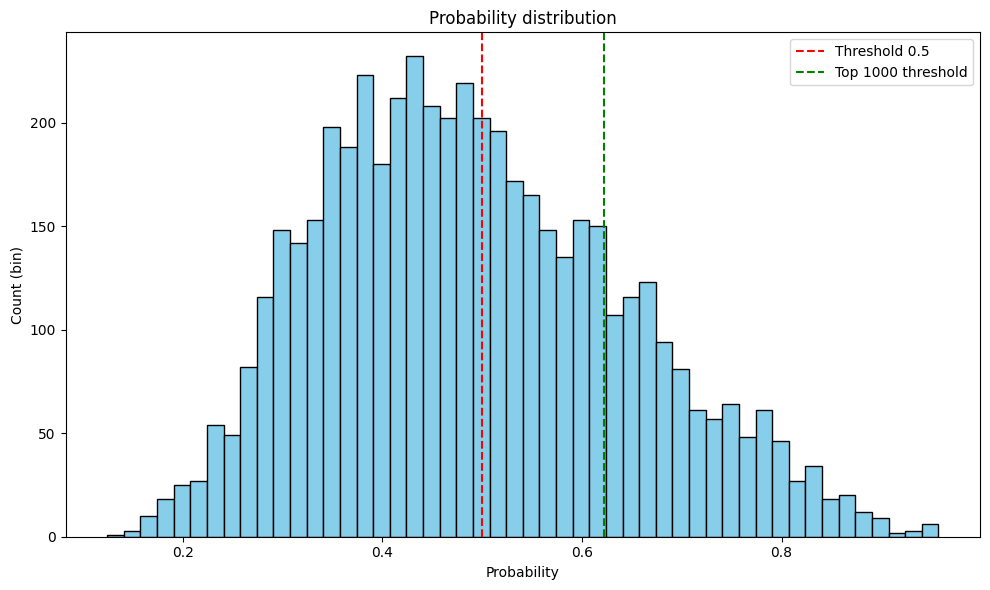

In [50]:
fit_and_plot(X, y, LogisticRegression(random_state=10), [8], X_test)

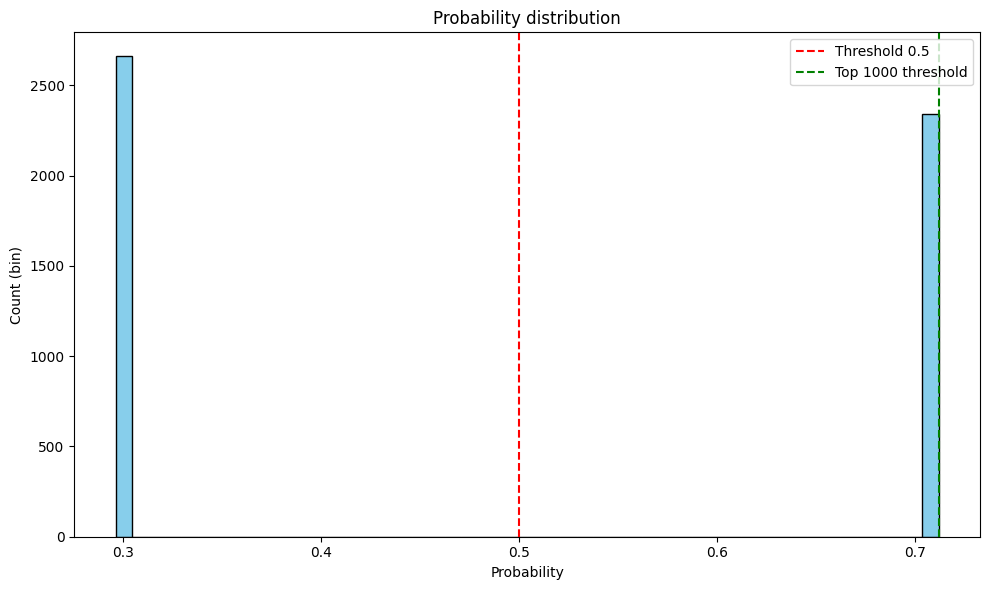

In [55]:
fit_and_plot(X, y, BernoulliNB(), [2], X_test)

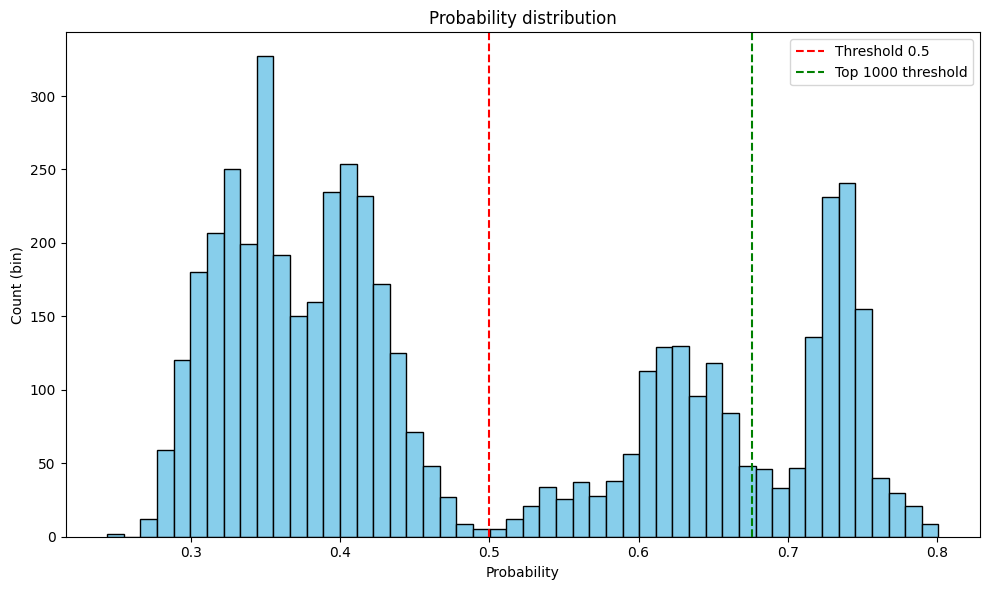

In [51]:
fit_and_plot(X, y, RandomForestClassifier(max_depth=5, random_state=10), [8, 139], X_test)

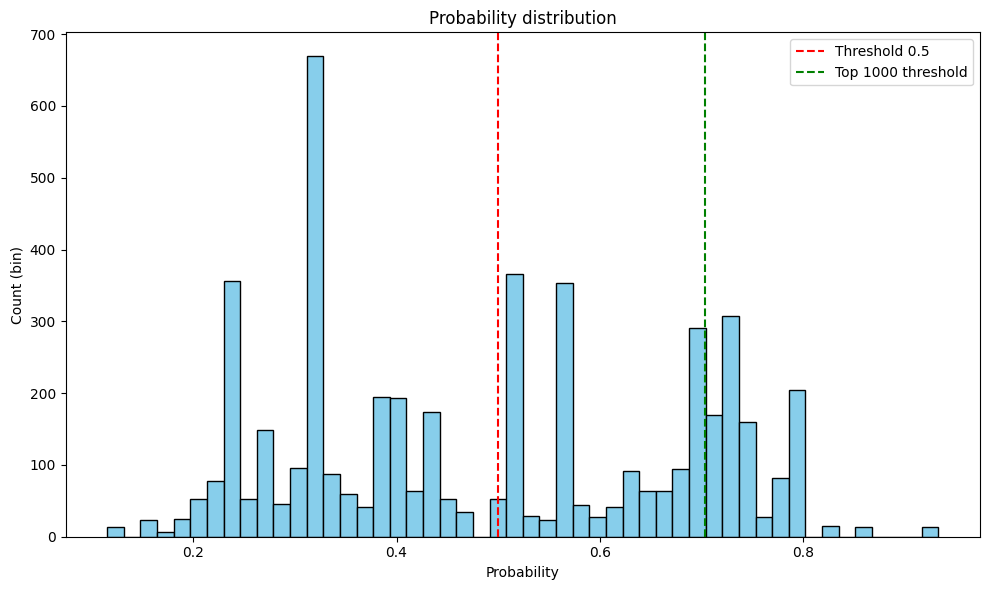

In [52]:
fit_and_plot(X, y, GradientBoostingClassifier(random_state=10), [3], X_test)